In [1]:
import glob
import warnings
warnings.filterwarnings('ignore')
from osgeo import gdal
from shapely import wkt
from typing import *
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline


from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import *
from fastai.metrics import  CMScores
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass


def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj




In [2]:
def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
                             dtype=torch.uint8,
                             device=indices.device)
#         return onehot.scatter_(1, indices.int().unsqueeze(1), 1)
        return onehot.scatter_(1, indices.long().unsqueeze(1), 1)

In [3]:
def colorize_mask_(mask, color_map=None):
    """
    Attaches a color palette to a PIL image. So long as the image is saved as a PNG, it will render visibly using the
    provided color map.
    :param mask: PIL image whose values are only 0 to 4 inclusive
    :param color_map: np.ndarray or list of 3-tuples with 5 rows
    :return:
    """
    color_map = color_map or np.array([(0, 0, 0),  # 0=background
                                       (255, 0, 0),  # no damage (or just 'building' for localization)
                                       (0, 255, 0),  # minor damage
                                       (0, 0, 255),  # major damage
                                       (128, 128, 0),  # destroyed
                                       (0, 128, 128),  # unclassified
                                       ])
    assert color_map.shape == (5, 3)
    mask.putpalette(color_map.astype(np.uint8))
    return None

In [4]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"
test_images_crops = data_dir / "test_crops"
test_mask_crops = data_dir / "test_mask_crops_single_channel"
models_path = data_dir / "models"

In [5]:
train_mask_crops.ls()[0]

PosixPath('/media/wwymak/Storage/xView2/mask_crops_single_channel/mask_socal-fire_00000501_pre_disaster._1.png')

In [6]:
unique_img_ids_undamaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'pre' in x.name ]))
unique_img_ids_damaged= list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() if 'post' in x.name ]))

print(len(unique_img_ids_damaged), len(unique_img_ids_undamaged))

np.random.seed(42)
np.random.shuffle(unique_img_ids_undamaged)
train_ids_undamaged = unique_img_ids_undamaged[:int(0.8 * len(unique_img_ids_undamaged))]
valid_ids_undamaged = unique_img_ids_undamaged[int(0.8 * len(unique_img_ids_undamaged)):]

train_ids_damaged = [x.replace('pre', 'post') for x in train_ids_undamaged]
valid_ids_damaged =[x.replace('pre', 'post') for x in valid_ids_undamaged]

print(len(train_ids_damaged), len(valid_ids_damaged))

2283 2283
1826 457


In [7]:
def is_valid_func(fname, valid_ids):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

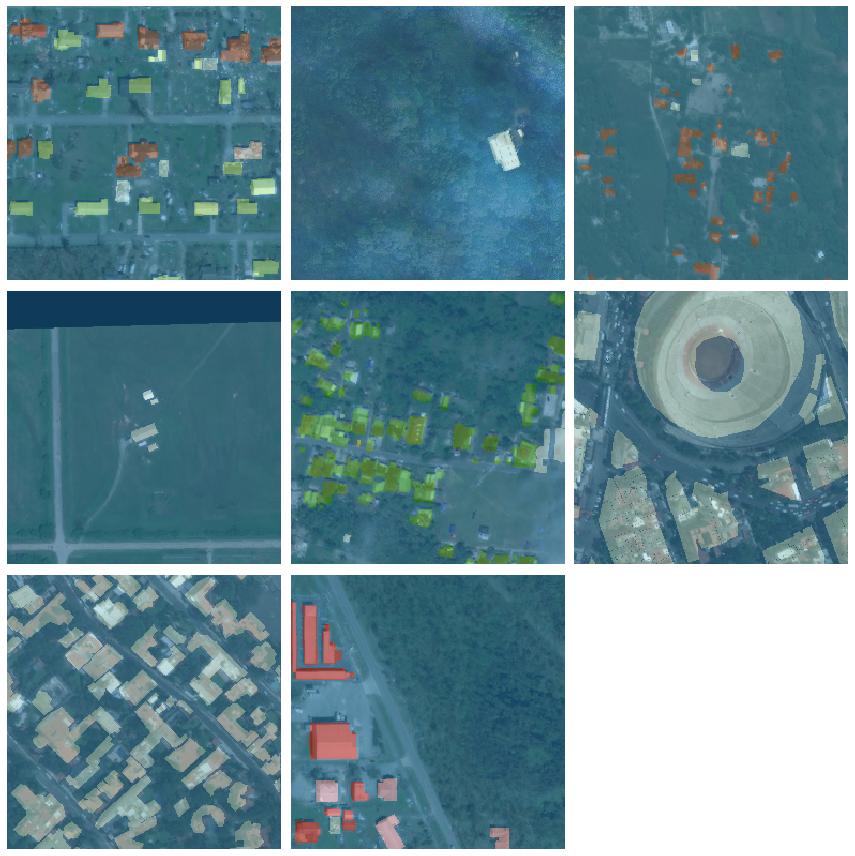

In [8]:
size=256
bs=8
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=False)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src_post = (SegItemListCustom.from_folder(train_images_crops)
       .filter_by_func(lambda fname: 'post_' in Path(fname).name)
      .split_by_valid_func(partial(is_valid_func, valid_ids=valid_ids_damaged))
       .label_from_func(get_mask_fn, 
            classes=['void', 'no-damage', 'minor-damage', 'major-damage', 'destroyed', 'un-classified']))

data = (src_post.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.show_batch(ds_type=DatasetType.Valid)

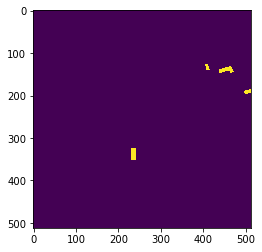

In [12]:
plt.imshow(np.array(PIL.Image.open('/media/wwymak/Storage/xView2/mask_crops_single_channel/mask_midwest-flooding_00000417_post_disaster._4.png')) *255/4)

In [13]:
# from fastai.vision.models.efficientnet import EfficientNetB7

accuracy_pixel=partial(foreground_acc, void_code=0)


wd =1e-2

metrics = [accuracy_pixel, dice, ]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.to_fp16();
# learn.lr_find()
# learn.recorder.plot();

In [9]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        print(last_output.shape, last_target.shape)
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm

In [50]:
lr=1e-3
# models_path = data_dir / "models"
# learn.model_dir = models_path
# callbacks=[SaveModelCallback(learn, every='improvement', monitor='f1_score', name='xview_buildings_default_unet'),
# #           TerminateOnNaNCallback(),
#            ReduceLROnPlateauCallback(learn, patience=1)
#           ]

learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.239758,0.227311,0.417011,0.468310,04:19
1,0.203329,0.200919,0.370401,0.623567,04:19
2,0.195236,0.188748,0.428852,0.612442,04:19


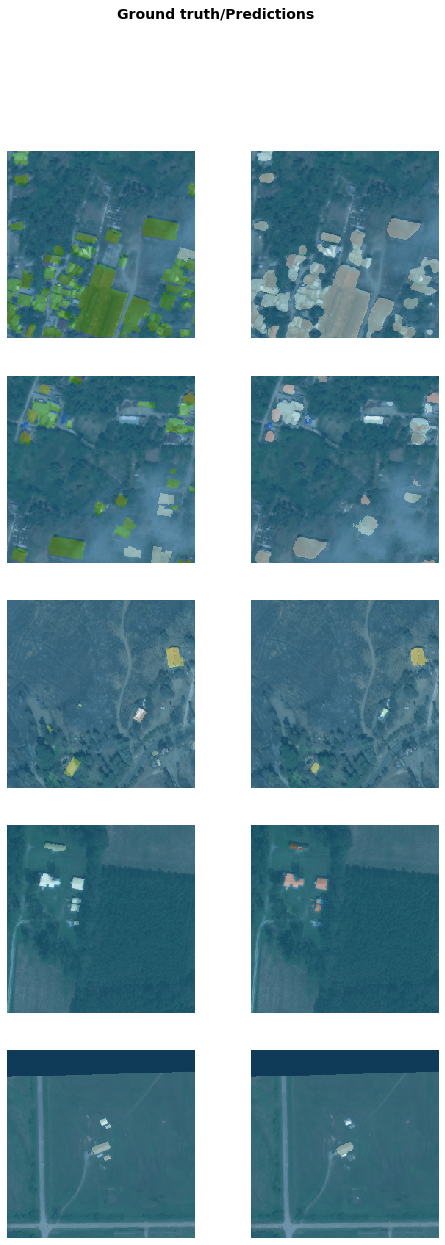

In [51]:
learn.show_results()

In [59]:
b = unet_learner(data, models.resnet18)
b.loss_func

FlattenedLoss of CrossEntropyLoss()

In [61]:
class CombinedLossFocal(nn.Module):

    def __init__(self, frac_focal=0.5, frac_ce=0.5):
        super(CombinedLossFocal, self).__init__()
        self.frac_focal = frac_focal
        self.frac_ce = frac_ce

    def forward(self, inputs, targets, **kwargs):
        #torch.Size([8, 6, 256, 256]) torch.Size([8, 1, 256, 256])
        ce_loss = CrossEntropyFlat(axis=1)(inputs, targets)
        
        focal_loss = FocalLossMultiClass(gamma=2., alpha=0.25)
        
        total_loss = self.frac_ce * ce_loss + \
                self.frac_focal * focal_loss(inputs, targets)
        return total_loss

In [62]:
learn.loss_func = CombinedLossFocal()

In [63]:
lr=1e-5
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.525383,0.505935,0.298562,0.359645,04:25
1,0.415080,0.414772,0.384310,0.539627,04:27
2,0.411867,0.413437,0.411804,0.574683,04:28


In [64]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.408594,0.410420,0.422510,0.590407,04:30
1,0.412643,0.408141,0.415182,0.584260,04:24
2,0.407887,0.408330,0.439480,0.614039,04:25


In [65]:
learn.model_dir = models_path
learn.save('25Dec-segmentation-damage-cls-focalloss')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


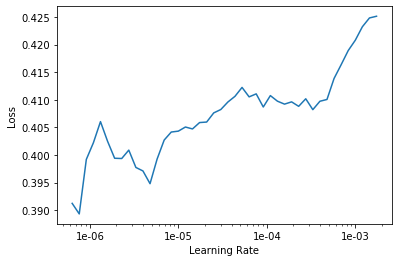

In [66]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [67]:
lr = 1e-6

learn.fit_one_cycle(3, slice(lr/5, lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.410454,0.407779,0.419900,0.591155,04:28
1,0.412571,0.407840,0.432389,0.602687,04:30
2,0.416581,0.407681,0.431127,0.605657,04:35


In [68]:
learn.fit_one_cycle(5, slice(lr/5, lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.408022,0.407765,0.438527,0.618970,04:36
1,0.414286,0.407156,0.416927,0.594897,04:57
2,0.406586,0.407309,0.429177,0.602116,04:55
3,0.408296,0.407013,0.430210,0.609528,04:34
4,0.410283,0.407372,0.437878,0.617277,04:35


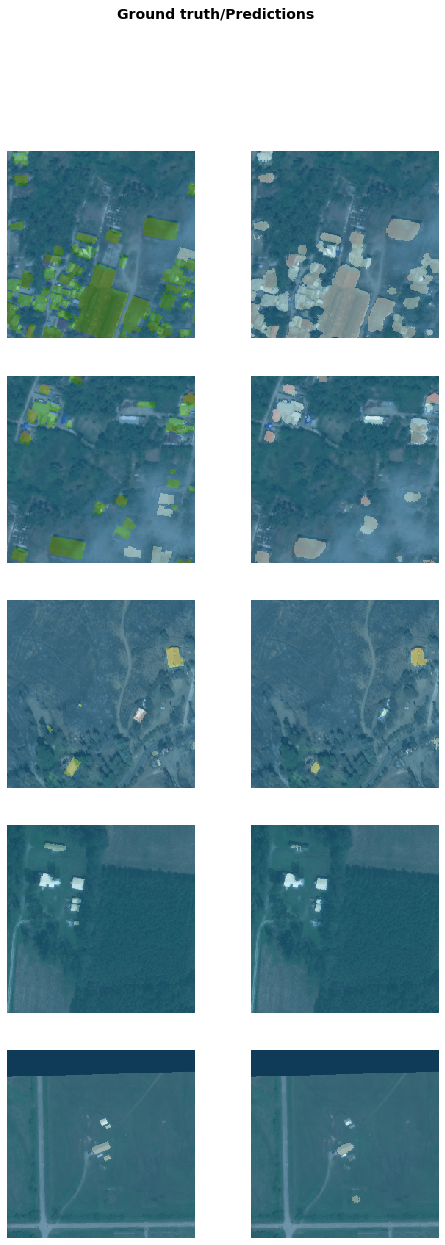

In [69]:
learn.show_results()

In [70]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

In [14]:
# metrics = [accuracy_pixel, dice, ]
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.model_dir = models_path
learn.load('25Dec-segmentation-damage-cls-focalloss');


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


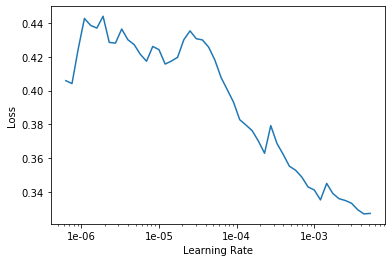

In [15]:
bs=4
size=512

data = (src_post.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn.to_fp32()
learn.data = data
learn.to_fp16()
learn.freeze()
learn.lr_find()
learn.recorder.plot();

In [16]:
lr = 5e-4
learn.fit_one_cycle(3, max_lr=lr)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.221607,0.181351,0.445222,0.602920,14:55
1,0.195968,0.184322,0.409776,0.597839,15:00
2,0.172969,0.164597,0.504234,0.695889,16:50


In [17]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

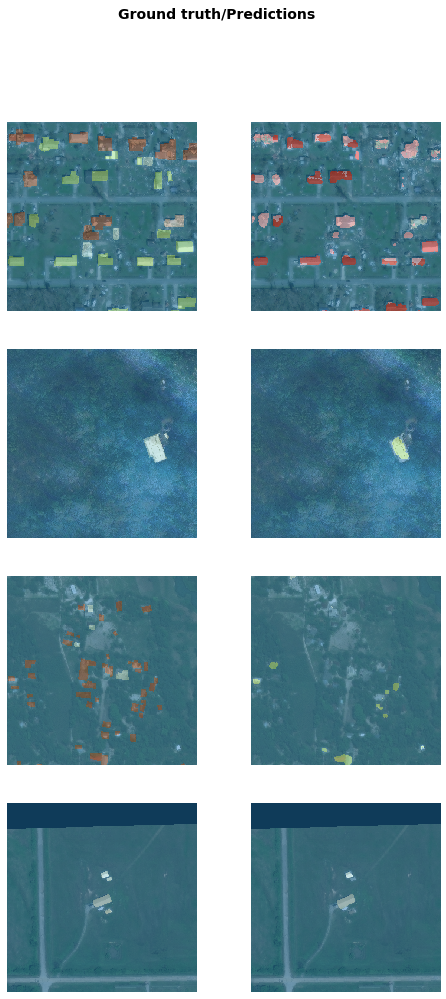

In [18]:
learn.show_results()

In [19]:
learn.fit_one_cycle(3, max_lr=lr/5)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.178225,0.162481,0.525690,0.692040,18:06
1,0.164936,0.161290,0.547922,0.761108,18:10
2,0.176138,0.158867,0.528851,0.740359,15:52


In [20]:
learn.save('25Dec-segmentation-damage-cls-focalloss')

In [21]:
learn.fit_one_cycle(3, max_lr=lr/25)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.174806,0.157666,0.523674,0.742173,16:12
1,0.168362,0.159732,0.521980,0.738962,14:35
2,0.160377,0.158241,0.527313,0.738298,14:54


hmm, what about adding mae to the loss function?  

(since the further away the predicted label is from the target value th worse it is)